In [1]:
%config Completer.use_jedi = False

from IPython import display
import logging
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import layers, losses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture

seed = 1
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [21]:
# configs
latent_dim = 1024
batch_size = 32
channel = 2

# logger
logging.basicConfig(level = logging.INFO)

In [5]:
def preprocess_images(images,channel):
    #images=images[:,:,:,channel] # channel
    #images = images.reshape((images.shape[0], 32, 32,3, 1)) / 255.
    return images/255.
train_images = preprocess_images(train_images,channel)
test_images = preprocess_images(test_images,channel)

In [6]:
train_images.shape

(50000, 32, 32, 3)

In [7]:
class CAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CAE, self).__init__()
        self.latent_dim = latent_dim
        self.logger = logging.getLogger('CAE')
        self.encoder = tf.keras.Sequential(name='encoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(name='decoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=8 * 8 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )

        self.encoder.summary()
        self.decoder.summary()
        
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


cae = CAE(latent_dim)
cae.compile(optimizer='adam', loss=losses.MeanSquaredError())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              2099200   
________________________________

In [8]:
cae.fit(x=train_images,y=train_images,validation_data=(test_images,test_images),epochs=10,\
        shuffle=True,batch_size=batch_size)

Epoch 1/10
1563/1563 [==============================] - 76s 48ms/step - loss: 0.0228 - val_loss: 0.0046
Epoch 2/10
1563/1563 [==============================] - 76s 49ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 3/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 4/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 5/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 6/10
1563/1563 [==============================] - 77s 50ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/10
1563/1563 [==============================] - 74s 48ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/10
1563/1563 [==============================] - 75s 48ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/10
1563/1563 [==============================] - 75s 48ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/10
1563/1563 [==============================] - 80s 51m

In [14]:
z = cae.encoder(test_images).numpy()
decoded_imgs = cae.decoder(z).numpy()

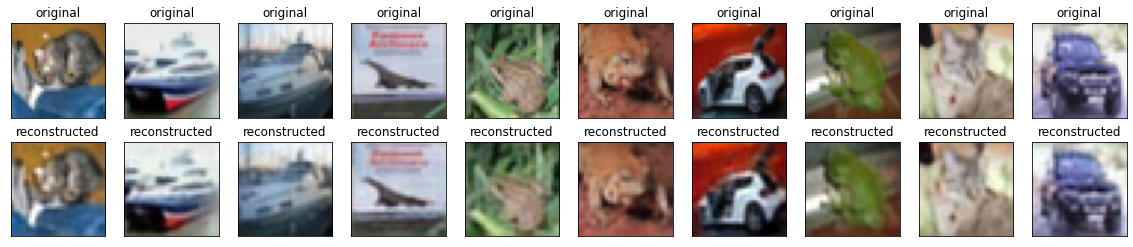

In [15]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
def create_Gaussian_Mixture_Model(samples_tensor,k_list=[6,8,10,12]):
    logger = logging.getLogger('create_Gaussian_Mixture_Model')
    
    samples_np = samples_tensor.numpy()
    min_aic,gm_min_aic = None,None
    for k in k_list:
        gm = GaussianMixture(n_components=k,covariance_type='diag').fit(samples_np)
        gm_means = gm.means_
        gm_cov = gm.covariances_
        at_k_msg = f'At K = {k}'
        logger.debug(f'{at_k_msg} - GM means = {gm_means}')
        logger.debug(f'{at_k_msg} - GM cov = {gm_cov}')
        aic = gm.aic(samples_np)
        logger.debug(f'{at_k_msg} - GM AIC = {aic}')
        logger.debug(f'{at_k_msg} - GM Weight {gm.weights_}')
        if min_aic is None:
            min_aic,gm_min_aic = aic,gm
        elif aic < min_aic:
            min_aic,gm_min_aic = aic,gm
        logger.debug('------------------------------------')
    
    # create tensorflow gm
    dist_list = []
    for i in range(len(gm_min_aic.means_)):
        means_ = tf.convert_to_tensor(gm_min_aic.means_[i],dtype=tf.float64)
        vars_ = tf.convert_to_tensor(gm_min_aic.covariances_[i],tf.float64)
        mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=means_,scale_diag=vars_)
        dist_list.append(mvn_diag)
    tf_gm = tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=gm_min_aic.weights_)\
                                      ,components=dist_list)
    return tf_gm

In [17]:
def calc_z_likelihood(z,raxis = 0):
    
    n = len(z)
    n_train = int(0.8*n)
    z_train = z[:n_train]
    z_test = z[n_train:]
    logger = logging.getLogger('calc_z_likelihood')
    
    sample_mean = tf.reduce_max(input_tensor=z_train,axis=raxis)
    sample_cov = tfp.stats.covariance(x=z_train)

    
    sample_var = tf.linalg.diag_part(input=sample_cov)+0.1

    mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=sample_mean,scale_diag=sample_var)
    #mvn_tri = tfp.distributions.MultivariateNormalTriL(loc=sample_mean,scale_tril=L)
    log_p_diag = tf.reduce_sum(mvn_diag.log_prob(z_test))
    
    # calculate GM model
    gm_diag = create_Gaussian_Mixture_Model(samples_tensor=z_test)
    log_p_gm_diag = tf.reduce_sum(gm_diag.log_prob(tf.cast(x=z,dtype=tf.float64)))
    
    #logger.debug(f'log_p_gm_diag = {log_p_gm_diag}')
    

    logp_dict = dict()
    logp_dict['GM_diag'] = log_p_gm_diag
    logp_dict['Gaus_diag'] = log_p_diag
    
    return logp_dict

INFO:Main:Training autoencoder for label 0


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_19 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


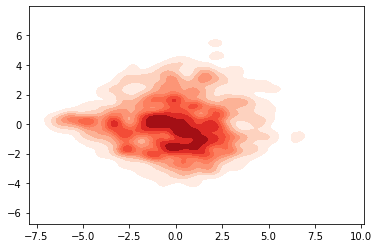

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[-0.14738283  0.00743745  0.14511327 ... -0.26361555  0.12146282
   0.05943739]
 [ 0.12224322  0.00060322  0.02821216 ...  0.13129776  0.50766226
  -0.01641573]
 [-0.17916085  0.03188137  0.00394195 ...  0.13305552  0.12380489
  -0.00104157]
 [-0.06213929  0.10619049  0.05528296 ... -0.06648095  0.3184045
  -0.01887158]
 [-0.07451075 -0.06633957  0.0996452  ...  0.08325438  0.33897983
   0.03422854]
 [ 0.08110842  0.02418445  0.00793821 ...  0.15069592  0.39610301
  -0.05962736]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[9.99195430e-07 1.00000175e-06 1.00036537e-06 ... 1.00218244e-06
  9.99758984e-07 9.99982203e-07]
 [3.12551251e-02 3.97440223e-02 2.58386302e-02 ... 4.32735322e-02
  1.23188559e-02 1.84751503e-02]
 [4.19700705e-02 5.27427850e-02 2.13635193e-02 ... 2.93290821e-02
  1.55395619e-02 2.49948792e-02]
 [2.58172692e-02 2.05030184e-02 3.24740555e-02 ... 3.55438089e-02
  1.31439314e-02 1.62755818e-02]
 [5.

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_20 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


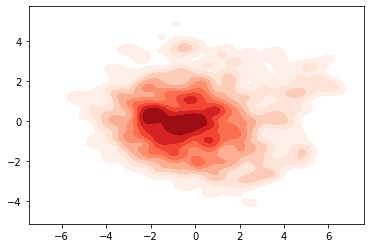

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[ 0.75993666  0.06962017  0.10397103 ... -0.18642515 -0.17105666
   0.00495932]
 [ 0.65967511  0.00517332  0.00219318 ... -0.05338146 -0.20261073
  -0.06071342]
 [ 1.0022615   0.00851222  0.19515282 ... -0.03090187 -0.36410221
  -0.1334094 ]
 [ 0.57653488 -0.02556446 -0.10388143 ... -0.02672351 -0.06205464
   0.04825235]
 [ 1.1178685  -0.20529477  0.14001516 ...  0.03115512 -0.34816933
   0.01396821]
 [ 0.87310583 -0.04256006 -0.12435607 ... -0.10072562 -0.11122646
   0.03099642]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[0.02019681 0.04479974 0.00125733 ... 0.00411502 0.00124801 0.00235766]
 [0.02674576 0.03689189 0.06351369 ... 0.04220829 0.02198361 0.024406  ]
 [0.01475853 0.03967944 0.07537329 ... 0.04033935 0.02779868 0.03725082]
 [0.03581734 0.04007577 0.03467136 ... 0.04130539 0.02817814 0.02889589]
 [0.05433036 0.03835819 0.08494873 ... 0.05014216 0.06613496 0.02313655]
 [0.01265038 0.03349742 0.03911608

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_21 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


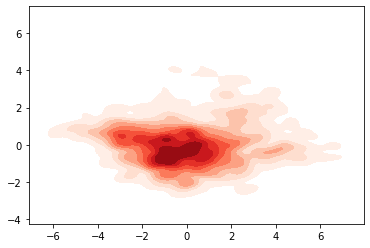

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[ 2.53824532e-01 -3.58222514e-01 -1.29577428e-01 ... -1.45594582e-01
   5.35838343e-02  7.97250122e-02]
 [-4.69705887e-02 -1.13331964e-01  5.00741579e-02 ...  2.08596062e-03
   4.49984974e-02  4.52555913e-04]
 [ 8.46212186e-02 -3.16960471e-01  1.56561904e-01 ...  1.78443203e-02
   5.11100120e-03  5.05014742e-02]
 [ 5.79716428e-02 -4.16815019e-01  4.22130328e-02 ... -3.31711389e-02
  -8.20602415e-02  7.80808835e-02]
 [ 4.30329744e-02 -6.70994592e-01 -1.77095610e-01 ... -1.09158053e-01
  -2.27526279e-02  1.80124584e-01]
 [ 1.23455851e-02 -2.40451450e-01  1.41755153e-02 ... -3.52569763e-02
   3.40961521e-02  5.00841095e-02]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[9.98444448e-07 1.00636217e-06 1.00004725e-06 ... 1.00053282e-06
  9.99917372e-07 1.00016677e-06]
 [1.76556170e-02 1.54428361e-02 2.27803565e-02 ... 1.10060743e-02
  2.43692119e-02 1.08095109e-02]
 [7.59830428e-03 1.71752379e-02 4.17882975e-02 ... 8.7670

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_22 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


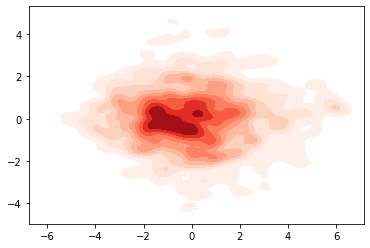

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[ 8.41431841e-02 -1.60306301e-02 -2.73748875e-01 ...  1.96619004e-01
  -1.58645794e-01  1.60304576e-01]
 [-2.82448033e-01  1.34600901e-01  6.58903242e-03 ...  2.45464515e-02
   1.02521300e-02  6.21580623e-02]
 [-2.26349387e-01  5.10368854e-02  1.28565808e-01 ... -4.15844344e-02
   1.18954269e-02  5.07200107e-02]
 [-2.40819720e-01  1.13599129e-01 -1.32875498e-02 ...  4.34842371e-02
   1.79399037e-05 -4.33759037e-02]
 [-3.49250775e-01  2.77701092e-01  1.74585551e-02 ...  1.14995783e-02
   1.91034245e-02 -4.77019014e-02]
 [-4.90293339e-01  3.35747126e-01 -7.22410865e-02 ...  1.16737626e-01
   5.97910136e-02 -9.54101933e-02]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[9.99896267e-07 9.99988178e-07 9.99903366e-07 ... 9.99695887e-07
  9.99913116e-07 1.00011826e-06]
 [1.87418967e-02 1.43569569e-02 2.40898544e-02 ... 2.29155821e-02
  1.12321237e-02 2.09635198e-02]
 [1.76082006e-02 6.17692219e-03 7.37660128e-04 ... 5.8453

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_23 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


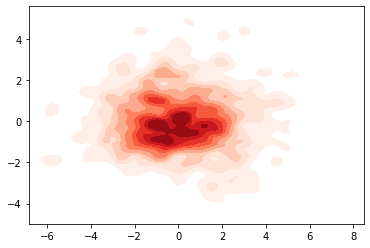

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[-0.02991676  0.08532853 -0.02539658 ...  0.08487162 -0.03979272
  -0.01557016]
 [-0.01621083 -0.04161808 -0.12510583 ...  0.21882277 -0.072609
  -0.02724868]
 [-0.08413761 -0.11232809 -0.17551594 ...  0.12189541 -0.06573284
  -0.17149035]
 [-0.13099302  0.11299302  0.20231636 ... -0.09181273 -0.00314866
   0.0313791 ]
 [ 0.01013058  0.0175528   0.08557026 ...  0.11951422 -0.10795408
  -0.03619788]
 [-0.02818589 -0.06313641 -0.07199748 ...  0.27999246 -0.04521216
   0.02964536]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[0.01516083 0.01471295 0.06880818 ... 0.00946313 0.01812307 0.03934022]
 [0.01395296 0.01402983 0.04292179 ... 0.01032116 0.0260805  0.02510096]
 [0.00310658 0.02338433 0.08152216 ... 0.00507191 0.04134927 0.01888112]
 [0.0104641  0.00431141 0.02057764 ... 0.02108842 0.0068507  0.01633733]
 [0.01549668 0.01447637 0.06739959 ... 0.01294287 0.02663642 0.01598451]
 [0.0129598  0.01567268 0.05180643 .

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_24 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


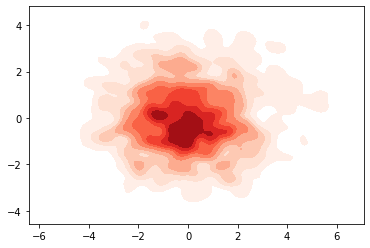

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[ 0.06658795  0.03960221  0.02444756 ...  0.03187789 -0.10429579
  -0.01204307]
 [-0.02408995  0.03723236 -0.06646006 ... -0.04300501 -0.183611
   0.03343944]
 [ 0.03181122  0.05677267  0.10846783 ...  0.10116083 -0.00145086
   0.00238884]
 [-0.06020421  0.03904642  0.00664897 ... -0.03568069 -0.15874318
  -0.02315708]
 [ 0.029411   -0.04260382 -0.04905999 ...  0.01180249  0.02168065
   0.04922976]
 [ 0.01975899  0.00281755  0.04546835 ...  0.06045015 -0.22849331
   0.05630053]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[0.0244429  0.00558488 0.01451351 ... 0.03145996 0.02318185 0.01123694]
 [0.013353   0.02119182 0.01431705 ... 0.01277616 0.02157101 0.01486123]
 [0.02427247 0.01059922 0.00792899 ... 0.03251852 0.01958348 0.00945909]
 [0.0258213  0.01065114 0.01369514 ... 0.04656604 0.01819816 0.01015577]
 [0.02573822 0.01217125 0.01230264 ... 0.02993764 0.03079316 0.00960177]
 [0.03165073 0.00838108 0.01154318 .

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_25 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


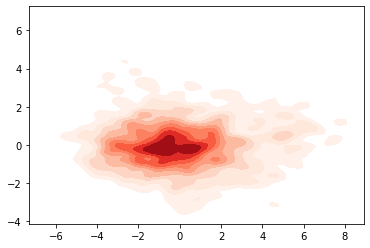

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[ 0.55661705  0.03825941  0.0420335  ... -0.01294324  0.26510767
   0.02171809]
 [ 0.84177645  0.01926362  0.01799106 ...  0.08250668 -0.57112954
  -0.1444609 ]
 [ 0.79387163  0.07189317  0.031022   ...  0.01455775 -0.16317014
  -0.09843523]
 [ 0.75704078  0.01301213 -0.00366148 ...  0.05591927  0.06132784
   0.00760581]
 [ 0.64680644  0.0601885   0.042812   ... -0.00443178  0.11391339
  -0.02546953]
 [ 0.61240268  0.10286373  0.03930101 ...  0.04970083 -0.50962795
  -0.02391357]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[0.02412092 0.01001278 0.01801012 ... 0.01005399 0.05350823 0.01570207]
 [0.04123179 0.03901194 0.03810189 ... 0.02479316 0.07597839 0.01411319]
 [0.01012707 0.02096498 0.01279578 ... 0.02382619 0.04942331 0.01297206]
 [0.01056018 0.01126726 0.01836052 ... 0.01258229 0.02948628 0.0062503 ]
 [0.01374256 0.01606906 0.01925947 ... 0.02343354 0.04773258 0.00962151]
 [0.02113071 0.01835312 0.01491789

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_26 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


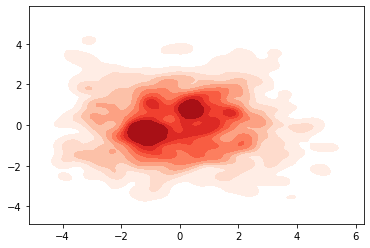

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[-0.5229131   0.05163793  0.41807497 ...  0.06488968 -0.23507962
   0.11148132]
 [-0.60076315 -0.06807202  0.41063592 ... -0.04595032  0.04075316
  -0.12872224]
 [-0.60710134 -0.05955849  0.25652048 ... -0.09164185 -0.01758745
  -0.05290109]
 [-0.85009652 -0.02756854  0.40314481 ... -0.01884373 -0.07552875
  -0.25517311]
 [-0.43135814 -0.04971017  0.33282105 ... -0.02111235  0.07496297
  -0.00629385]
 [-0.59847234  0.01722623  0.26731247 ...  0.00757108  0.02251269
  -0.10584183]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[9.87635861e-07 1.00009343e-06 9.95237531e-07 ... 9.99813219e-07
  1.00177344e-06 9.99553529e-07]
 [1.04567685e-02 1.53141269e-02 1.65100727e-02 ... 1.96764853e-02
  1.78148652e-02 9.23912244e-03]
 [3.09024418e-02 4.38166287e-02 3.38426927e-02 ... 1.38013291e-02
  2.19316463e-02 2.12358260e-02]
 [2.61374262e-02 3.26218439e-02 3.19425749e-02 ... 4.16135153e-02
  1.34218469e-02 1.60502059e-02]
 [3

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_27 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


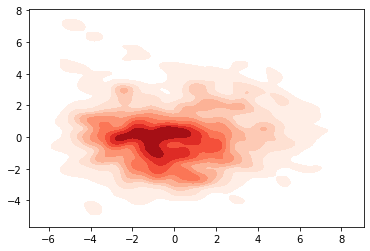

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[ 0.04616113  0.02217021  0.00129349 ... -0.00142529 -0.09387446
  -0.04426418]
 [ 0.19240843 -0.05282621 -0.25979009 ... -0.20985354 -0.05585749
   0.19083165]
 [ 0.00720376 -0.01248823  0.06000533 ... -0.03054207 -0.01302063
   0.1092124 ]
 [-0.00107959 -0.04401413 -0.07607892 ... -0.01653799 -0.04351352
   0.00402287]
 [ 0.02879618 -0.02139072  0.04735992 ...  0.03063558  0.00704186
   0.04836054]
 [ 0.43576553 -0.0654189  -0.28044373 ...  0.29300168 -0.24022847
   0.17859715]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[4.17233147e-02 2.19466163e-02 2.52868466e-02 ... 4.47140103e-02
  5.02238697e-02 3.76073781e-02]
 [1.26293233e-02 2.28905148e-02 7.31498491e-02 ... 4.89565479e-02
  7.50679984e-02 3.55857423e-02]
 [2.65505009e-02 1.55543259e-02 4.44042597e-02 ... 3.87003061e-02
  2.64856147e-02 2.96044718e-02]
 [2.30649304e-02 3.27258274e-02 3.35244595e-02 ... 3.06542937e-02
  6.73311743e-02 5.67188925e-02]
 [2

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_28 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              3212288   
Total params: 3,231,680
Trainable params: 3,231,680
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 2048)              2099200   
________________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


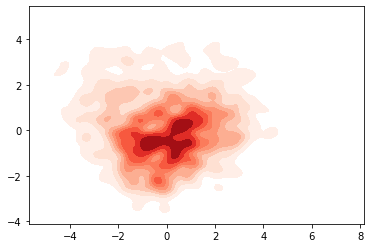

DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM means = [[-0.18096508 -0.14665785 -0.18103625 ... -0.08796629  0.17069514
   0.07165846]
 [ 0.02914082  0.00240546  0.0702334  ... -0.06361208  0.01167124
   0.00543535]
 [ 0.02906261 -0.03159847 -0.10335893 ...  0.00104471 -0.03052101
   0.04156419]
 [-0.02659295 -0.00570982 -0.04382504 ...  0.03511251 -0.07096385
   0.03971334]
 [ 0.00976251  0.02777174 -0.03111468 ... -0.02429813  0.0554584
  -0.02181299]
 [ 0.06740761 -0.00459903  0.03423844 ... -0.00823806 -0.02784116
   0.06069936]]
DEBUG:create_Gaussian_Mixture_Model:At K = 6 - GM cov = [[9.99697135e-07 9.99823664e-07 1.00091381e-06 ... 9.99978690e-07
  9.99794228e-07 9.99807932e-07]
 [2.48354650e-02 2.95560351e-02 4.71497594e-02 ... 2.23537946e-02
  3.48534892e-02 2.27746559e-02]
 [3.71761566e-02 2.78911719e-02 3.50460754e-02 ... 3.13179802e-02
  3.17934976e-02 2.43588051e-02]
 [3.33602722e-02 2.63761494e-02 8.63011690e-03 ... 1.43419742e-02
  2.22533099e-02 1.45060585e-02]
 [3.

In [22]:
# Main snippet for Z posterior estimation via boostrapping
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('Main')
caes = dict()
train_labels2 = np.transpose(train_labels)[0]
test_labels2 = np.transpose(test_labels)[0]
labels_logps_dict = dict()
unique_labels = np.unique(train_labels)
for label in unique_labels:
    train_idx = train_labels2==label
    test_idx = test_labels2 == label
    
    train_images_label = train_images[train_idx,:,:]
    test_images_label = test_images[test_idx,:,:]

    logger.info(f'Training autoencoder for label {label}')
    caes[label]  = CAE(latent_dim)
    caes[label].compile(optimizer='adam', loss=losses.MeanSquaredError())
    caes[label].fit(train_images_label, train_images_label,
                epochs=10,
                shuffle=True,
                batch_size=batch_size,
                validation_data=(test_images_label, test_images_label))
    
    z = caes[label].encoder(test_images_label)
    if z.shape[0] >2:
        logger.info('Apply PCA for 2D plot of Z')
        s = StandardScaler()
        z_scaled = s.fit(z)
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)
        z1 = z_pca[:,0]
        z2 = z_pca[:,1]
    elif z.shape[0] == 2:
        z1 = z[:,0].numpy()
        z2 = z[:,1].numpy()
    else:
        raise ValueError('Z shape must be >=2')
    sns.kdeplot(pd.Series(z1), pd.Series(z2), cmap="Reds", shade=True, bw=.15)
    plt.show()
    
    logps = calc_z_likelihood(z=z)
    logger.info(f"""For label {label} log_p_gm_diag = {logps['GM_diag']}""")
    logger.info(f"""For label {label} log_p_gaus_diag = {logps['Gaus_diag']}""")
    logger.info(f"""For lable {label} ratio log_p_gm_diag / log_p_mvn_diag = \
            {np.round(logps['GM_diag']/ tf.cast(logps['Gaus_diag'],tf.float64),3)}""")
    entry = {'log_p_gm_diag':logps['GM_diag'].numpy(),'log_p_gaus_diag':logps['Gaus_diag'].numpy(),\
             'ratio_log_p_gm_diag_over_log_p_mvn_diag': \
             np.round(logps['GM_diag'].numpy()/logps['Gaus_diag'].numpy())}
    labels_logps_dict[label] = entry
    

In [23]:
labels_logps_dict

{0: {'log_p_gm_diag': -13952863.303928085,
  'log_p_gaus_diag': -2258350.0,
  'ratio_log_p_gm_diag_over_log_p_mvn_diag': 6.0},
 1: {'log_p_gm_diag': -21515461.09378787,
  'log_p_gaus_diag': -2222067.8,
  'ratio_log_p_gm_diag_over_log_p_mvn_diag': 10.0},
 2: {'log_p_gm_diag': -35939193.63918927,
  'log_p_gaus_diag': -2039170.8,
  'ratio_log_p_gm_diag_over_log_p_mvn_diag': 18.0},
 3: {'log_p_gm_diag': -35404228.990113735,
  'log_p_gaus_diag': -1938486.8,
  'ratio_log_p_gm_diag_over_log_p_mvn_diag': 18.0},
 4: {'log_p_gm_diag': -33485150.168595344,
  'log_p_gaus_diag': -2075903.6,
  'ratio_log_p_gm_diag_over_log_p_mvn_diag': 16.0},
 5: {'log_p_gm_diag': -36568822.19096918,
  'log_p_gaus_diag': -1837886.8,
  'ratio_log_p_gm_diag_over_log_p_mvn_diag': 20.0},
 6: {'log_p_gm_diag': -26465892.58753369,
  'log_p_gaus_diag': -1973970.2,
  'ratio_log_p_gm_diag_over_log_p_mvn_diag': 13.0},
 7: {'log_p_gm_diag': -27904807.763602704,
  'log_p_gaus_diag': -2075317.8,
  'ratio_log_p_gm_diag_over_log_p